# Iterative Mistake Minimization Algorithm

## Algorithm

```text
class Node:
# A class to represent a decision node or leaf in a decision tree
Initialize with cluster label, left and right children, feature and value

class IMM:
# IMM algorithm for clustering using a decision tree approach
Initialize with the number of clusters, k

function fit(X):
    # Fit the IMM algorithm to the data
    Perform k-means clustering on the dataset X with k clusters
    Assign the k-means cluster centers to u
    Assign the k-means cluster labels to y
    Build the decision tree using the build_tree method

function build_tree(X, y, u):
    # Recursive function to build the decision tree
    If all labels in y are the same, return a leaf node with the cluster label
    For each feature i in the dataset:
        Calculate the range of cluster centers for feature i
        Determine the cutoff value as the mean of the min and max center values
        Count mistakes for each potential split at the cutoff value
    Find the feature i with the minimum mistakes for the split
    Split the dataset into left and right subsets based on the best feature's cutoff value
    Recursively call build_tree on the left and right subsets
    Create and return a decision node with the chosen feature and cutoff value

function mistake(x, u, i, theta):
    # Function to calculate whether a data point x makes a mistake relative to center u
    # at threshold theta on feature i
    Return 1 if there's a mistake, otherwise 0

function predict(x):
    # Function to predict the cluster for a new data point x
    Traverse the decision tree to find the leaf node's cluster for x

function traverse(tree, x):
    # Helper function to traverse the decision tree with a data point x
    If at a leaf node, return the cluster label
    If the data point's value for the current node's feature is less than or equal to the node's value
        Traverse left
    Else
        Traverse right
```

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import json
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [65]:
class Node:
    def __init__(self, cluster=None, left=None, right=None, feature=None, value=None):
        self.cluster = cluster
        self.left = left
        self.right = right
        self.feature = feature
        self.value = value

class IMM:
    def __init__(self, k):
        self.k = k
        self.tree = None

    def fit(self, x):
        clt = KMeans(n_clusters=self.k, random_state=0)
        y = clt.fit_predict(x)
        u = clt.cluster_centers_
        self.tree = self.build_tree(x, y, u)

    def build_tree(self, x, y, u):
        if np.all(y == y[0]):
            return Node(cluster=y[0])

        best_mistakes = float('inf')
        best_feature = None
        best_threshold = None
        best_split = None

        for i in range(x.shape[1]):
            idx_sorted = np.argsort(x[:, i])
            x_sorted = x[idx_sorted]
            y_sorted = y[idx_sorted]
            mistakes_left = 0
            mistakes_right = sum((x_sorted[:, i] > u[y_sorted, i]))

            for j in range(1, len(x)):
                if x_sorted[j - 1, i] == x_sorted[j, i]:
                    continue
                if x_sorted[j - 1, i] <= u[y_sorted[j - 1], i]:
                    mistakes_left += 1
                else:
                    mistakes_right -= 1

                if mistakes_left + mistakes_right < best_mistakes:
                    best_mistakes = mistakes_left + mistakes_right
                    best_feature = i
                    best_threshold = (x_sorted[j - 1, i] + x_sorted[j, i]) / 2
                    best_split = j

        if best_feature is not None:
            idx_sorted = np.argsort(x[:, best_feature])
            left_indices = idx_sorted[:best_split]
            right_indices = idx_sorted[best_split:]

            left_node = self.build_tree(x[left_indices], y[left_indices], u)
            right_node = self.build_tree(x[right_indices], y[right_indices], u)

            return Node(feature=best_feature, value=best_threshold, left=left_node, right=right_node)

        majority_cluster = max(set(y), key=list(y).count)
        return Node(cluster=majority_cluster)

    def serialize_tree(self, node, depth=0):
        if node is None:
            return ""

        if node.cluster is not None:
            return "    " * depth + f"Cluster {node.cluster}\n"

        result = "    " * depth + f"Feature {node.feature} <= {node.value}?\n"
        result += self.serialize_tree(node.left, depth + 1)
        result += "    " * depth + f"Feature {node.feature} > {node.value}?\n"
        result += self.serialize_tree(node.right, depth + 1)
        return result

    def predict(self, x):
        return self.traverse(self.tree, x)

    def traverse(self, tree, x):
        if tree.cluster is not None:
            return tree.cluster

        if x[tree.feature] <= tree.value:
            return self.traverse(tree.left, x)
        else:
            return self.traverse(tree.right, x)



### Commented code

In [50]:
class Node:
    # A Node represents either a decision node that splits the data, or a leaf node (cluster center).
    def __init__(self, cluster=None, left=None, right=None, feature=None, value=None):
        self.cluster = cluster  # The cluster assigned to this node if it's a leaf node.
        self.left = left        # Left child node.
        self.right = right      # Right child node.
        self.feature = feature  # The feature index used for splitting at this node.
        self.value = value      # The threshold value for splitting.

class IMM:
    # The IMM class represents the Iterative Mistake Minimization algorithm for decision trees.
    def __init__(self, k):
        self.k = k      # Number of clusters to form.
        self.tree = None  # Root node of the decision tree.

    def fit(self, x):
        # Fit the IMM model to the data.
        clt = KMeans(n_clusters=self.k, random_state=0)  # Use KMeans to find cluster centers.
        y = clt.fit_predict(x)  # Cluster assignments for each point.
        u = clt.cluster_centers_  # Cluster center coordinates.
        self.tree = self.build_tree(x, y, u)  # Build the decision tree based on the data.

    def build_tree(self, x, y, u):
        # Recursive function to build a decision tree from the data.
        if np.all(y == y[0]):
            # If all data points have the same cluster, return a leaf node with that cluster.
            return Node(cluster=y[0])

        # Initialize variables to track the best split.
        best_mistakes = float('inf')
        best_feature = None
        best_threshold = None
        best_split = None

        # Evaluate each feature for potential splits.
        for i in range(x.shape[1]):
            idx_sorted = np.argsort(x[:, i])  # Sort data points by the current feature.
            x_sorted = x[idx_sorted]          # Sorted data matrix.
            y_sorted = y[idx_sorted]          # Sorted labels.

            # Initialize mistakes for each side of the threshold.
            mistakes_left = 0
            mistakes_right = sum(x_sorted[:, i] > u[y_sorted, i])

            # Iterate over possible thresholds to find the best split.
            for j in range(1, len(x)):
                # Avoid duplicate values for a potential threshold.
                if x_sorted[j - 1, i] == x_sorted[j, i]:
                    continue
                
                # Update mistake counts based on the threshold.
                if x_sorted[j - 1, i] <= u[y_sorted[j - 1], i]:
                    mistakes_left += 1
                else:
                    mistakes_right -= 1

                # If the current split has fewer mistakes, update the best split variables.
                if mistakes_left + mistakes_right < best_mistakes:
                    best_mistakes = mistakes_left + mistakes_right
                    best_feature = i
                    best_threshold = (x_sorted[j - 1, i] + x_sorted[j, i]) / 2
                    best_split = j

        # If a split was found that reduces mistakes, create child nodes recursively.
        if best_feature is not None:
            idx_sorted = np.argsort(x[:, best_feature])
            left_indices = idx_sorted[:best_split]
            right_indices = idx_sorted[best_split:]

            left_node = self.build_tree(x[left_indices], y[left_indices], u)
            right_node = self.build_tree(x[right_indices], y[right_indices], u)

            return Node(feature=best_feature, value=best_threshold, left=left_node, right=right_node)

        # If no split reduces mistakes, return a leaf node with the majority cluster.
        majority_cluster = max(set(y), key=list(y).count)
        return Node(cluster=majority_cluster)

    def serialize_tree(self, node, depth=0):
        # Serialize the tree structure to a string for display.
        if node is None:
            return ""

        if node.cluster is not None:
            # Leaf node.
            return "    " * depth + f"Cluster {node.cluster}\n"

        # Internal node.
        result = "    " * depth + f"Feature {node.feature} <= {node.value}?\n"
        # Recursively serialize the left and right subtrees.
        result += self.serialize_tree(node.left, depth + 1)
        result += "    " * depth + f"Feature {node.feature} > {node.value}?\n"
        result += self.serialize_tree(node.right, depth + 1)
        return result

    def predict(self, x):
        # Predict the cluster for a new data point x.
        return self.traverse(self.tree, x)
    
    def traverse(self, tree, x):
        # Helper function to traverse the tree based on the feature values of x.
        if tree.cluster is not None:
            # Return the cluster label if at a leaf node.
            return tree.cluster

        # Decide whether to go left or right based on the feature value of x and the node's threshold.
        if x[tree.feature] <= tree.value:
            return self.traverse(tree.left, x)
        else:
            return self.traverse(tree.right, x)


In [63]:
# Example usage
if __name__ == "__main__":
    X = np.random.rand(20, 4)  # Random dataset
    k = 3  # Number of clusters
    model = IMM(k)
    model.fit(X)
    print(model.serialize_tree(model.tree))

c:\Users\srush\anaconda3\envs\cudatest\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srush\anaconda3\envs\cudatest\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Feature 0 <= 0.33012777311355346?
    Cluster 2
Feature 0 > 0.33012777311355346?
    Feature 0 <= 0.4510476547891444?
        Feature 1 <= 0.23497947448021755?
            Cluster 0
        Feature 1 > 0.23497947448021755?
            Cluster 2
    Feature 0 > 0.4510476547891444?
        Feature 0 <= 0.5057931234949364?
            Cluster 0
        Feature 0 > 0.5057931234949364?
            Feature 3 <= 0.2995018558605699?
                Cluster 0
            Feature 3 > 0.2995018558605699?
                Feature 1 <= 0.05949230246804971?
                    Cluster 0
                Feature 1 > 0.05949230246804971?
                    Feature 0 <= 0.6380699720921588?
                        Cluster 1
                    Feature 0 > 0.6380699720921588?
                        Feature 3 <= 0.5672631212220955?
                            Cluster 0
                        Feature 3 > 0.5672631212220955?
                            Cluster 1



In [22]:
def plot_node(node, depth, pos, ax, node_pos, leaf_nodes, x_offset=0.5, y_offset=0.1, max_depth=None):
    if max_depth is None:
        max_depth = get_tree_depth(node)
    
    if node is None:
        return
    
    node_id = str(id(node))
    node_pos[node_id] = pos

    if node.cluster is not None:
        ax.text(pos[0], pos[1], f'Cluster {node.cluster}', bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1),
                ha='center', va='center')
        leaf_nodes.append(node_id)
    else:
        ax.text(pos[0], pos[1], f'Feature {node.feature}\n<= {node.value:.2f}', bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", ec="b", lw=1),
                ha='center', va='center')

    if node.left or node.right:
        # Calculate horizontal spacing dynamically based on tree depth
        x_spacing = x_offset / (2 ** (max_depth - depth))

        if node.left:
            left_pos = (pos[0] - x_spacing, pos[1] - y_offset)
            plot_node(node.left, depth + 1, left_pos, ax, node_pos, leaf_nodes, x_offset=x_offset, y_offset=y_offset, max_depth=max_depth)
            ax.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], 'k-', lw=1)

        if node.right:
            right_pos = (pos[0] + x_spacing, pos[1] - y_offset)
            plot_node(node.right, depth + 1, right_pos, ax, node_pos, leaf_nodes, x_offset=x_offset, y_offset=y_offset, max_depth=max_depth)
            ax.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], 'k-', lw=1)

def get_tree_depth(node):
    if node is None or node.cluster is not None:
        return 0
    return max(get_tree_depth(node.left), get_tree_depth(node.right)) + 1

def visualize_tree(tree, figsize=(20, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    max_depth = get_tree_depth(tree)
    node_pos = {}
    leaf_nodes = []
    plot_node(tree, 0, (0.5, 0.9), ax, node_pos, leaf_nodes, x_offset=0.5, y_offset=0.1, max_depth=max_depth)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

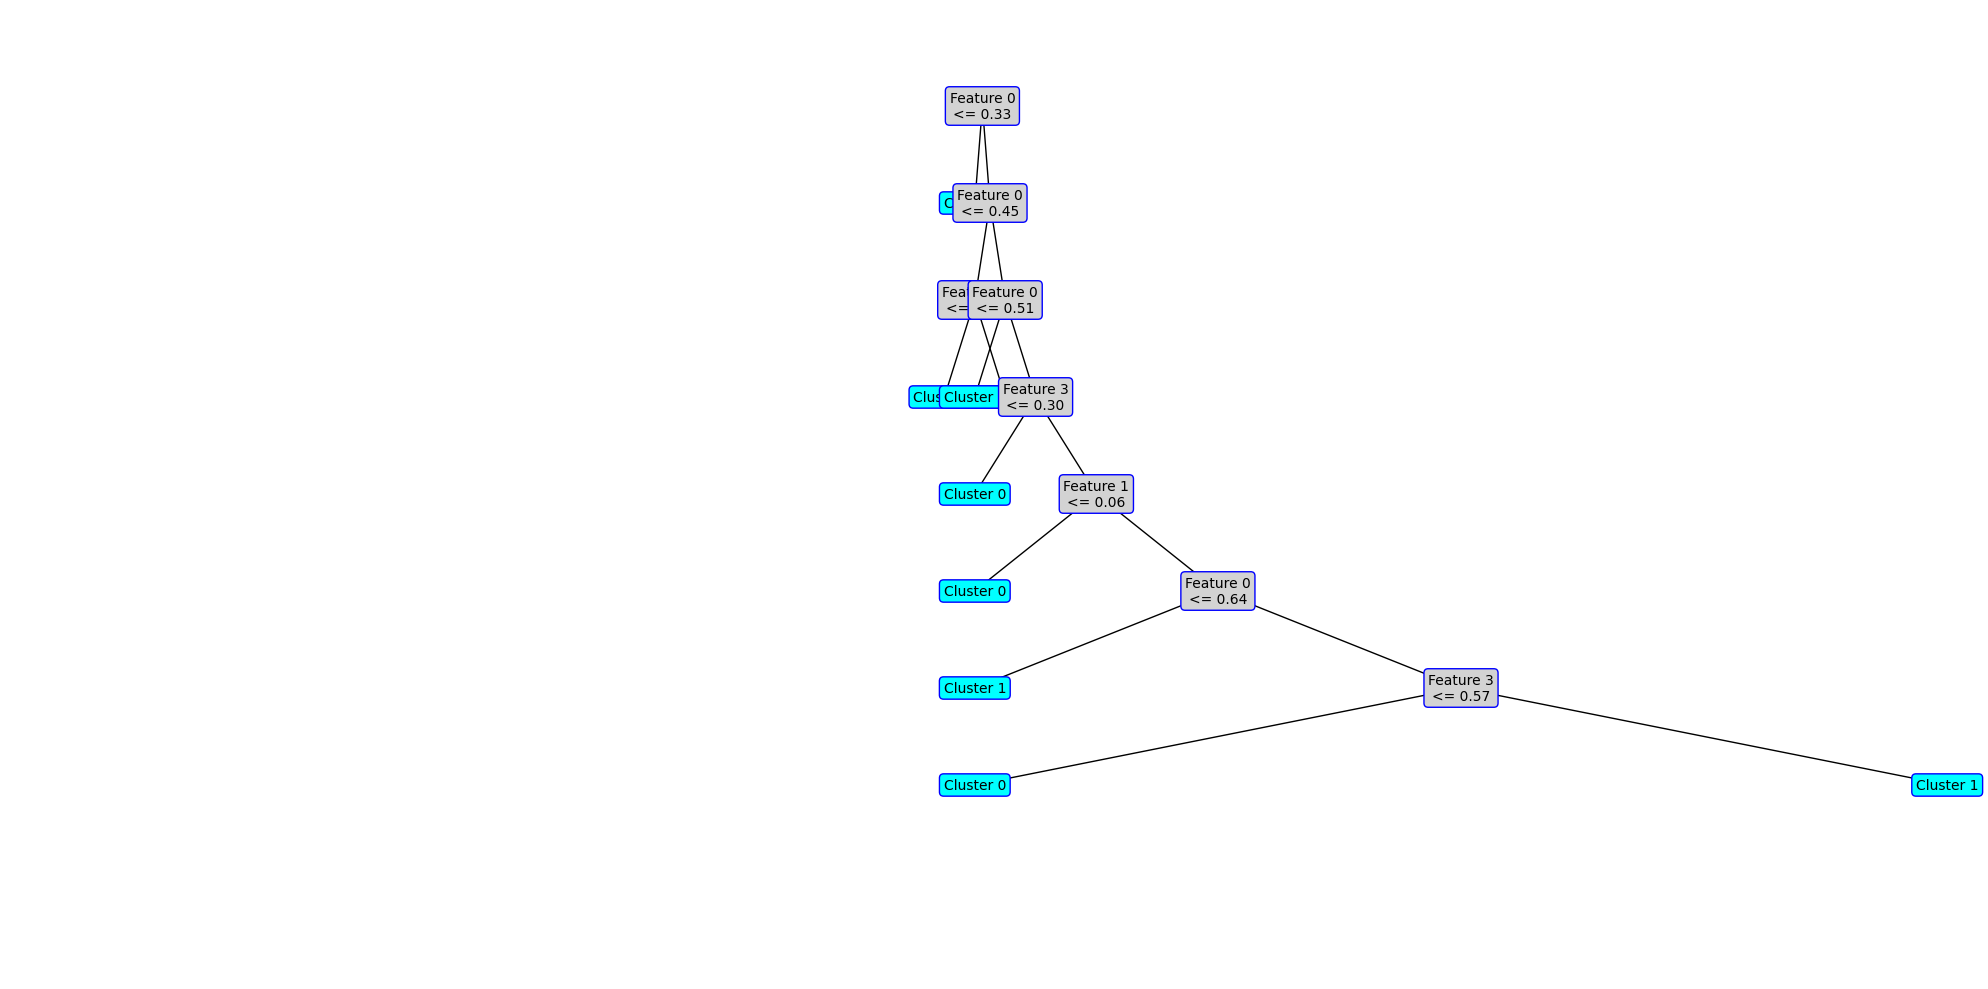

In [64]:
visualize_tree(model.tree)

# Implementing the IMM algorithm on sales data for customer segmentation analysis

In [27]:
df = pd.read_csv(r'C:\Users\srush\Customer_Segmentation\cleanedDataset.csv', encoding = 'ISO-8859-1')

In [28]:
df.columns

Index(['type', 'days_for_shipping', 'days_for_shipment', 'benefit_per_order',
       'delivery_status', 'late_delivery_risk', 'category_name',
       'customer_city', 'customer_country', 'customer_fname', 'customer_id',
       'customer_lname', 'customer_segment', 'customer_state',
       'customer_street', 'customer_zipcode', 'department_id',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_quantity', 'sales',
       'order_item_total', 'order_region', 'order_state', 'order_status',
       'product_card_id', 'product_name', 'product_price', 'shipping_mode',
       'order_year', 'order_month', 'order_date', 'shipping_year',
       'shipping_month', 'shipping_date', 'sales_id'],
      dtype='object')

In [29]:
# Select relevant columns for segmentation based on sales
col = ['order_item_quantity', 'sales', 'benefit_per_order', 'order_item_discount', 'order_item_total','order_date', 'shipping_date']

In [30]:
df_new = df[col]

In [31]:
df_new.head()

,order_item_quantity,sales,benefit_per_order,order_item_discount,order_item_total,order_date,shipping_date
0,1,327.75,91.250000,13.110000,314.640015,2018-01-31,2018-02-03
1,1,327.75,-249.089996,16.389999,311.359985,2018-01-13,2018-01-18
2,1,327.75,-247.779999,18.030001,309.720001,2018-01-13,2018-01-17
3,1,327.75,22.860001,22.940001,304.809998,2018-01-13,2018-01-16
4,1,327.75,134.210007,29.500000,298.250000,2018-01-13,2018-01-15


In [32]:
df_new.corr()

,order_item_quantity,sales,benefit_per_order,order_item_discount,order_item_total
order_item_quantity,1.000000,0.106442,0.015696,0.065379,0.105413
sales,0.106442,1.000000,0.131816,0.617438,0.989744
benefit_per_order,0.015696,0.131816,1.000000,0.064756,0.133484
order_item_discount,0.065379,0.617438,0.064756,1.000000,0.498734
order_item_total,0.105413,0.989744,0.133484,0.498734,1.000000


In [ ]:
# Convert 'OrderDate' and 'ShipDate' to datetime objects
df_new['order_date'] = pd.to_datetime(df_new['order_date'])
df_new['shipping_date'] = pd.to_datetime(df_new['shipping_date'])

In [34]:
# Calculate the duration between order and shipment
df_new['order_duration'] = (df_new['shipping_date'] - df_new['order_date']).dt.days

# Display the modified DataFrame
df_new.head()

C:\Users\srush\AppData\Local\Temp\ipykernel_77428\4026756548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['order_duration'] = (df_new['shipping_date'] - df_new['order_date']).dt.days


,order_item_quantity,sales,benefit_per_order,order_item_discount,order_item_total,order_date,shipping_date,order_duration
0,1,327.75,91.250000,13.110000,314.640015,2018-01-31,2018-02-03,3
1,1,327.75,-249.089996,16.389999,311.359985,2018-01-13,2018-01-18,5
2,1,327.75,-247.779999,18.030001,309.720001,2018-01-13,2018-01-17,4
3,1,327.75,22.860001,22.940001,304.809998,2018-01-13,2018-01-16,3
4,1,327.75,134.210007,29.500000,298.250000,2018-01-13,2018-01-15,2


In [35]:
# Select numerical columns for scaling
col = ['order_item_quantity', 'sales', 'benefit_per_order', 'order_item_discount', 'order_item_total','order_duration']

In [36]:
# Standardize the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new[col])

In [37]:
# Create a DataFrame with the scaled features
df_scaled = pd.DataFrame(df_scaled, columns=col)

# Display the scaled DataFrame
df_scaled.head()

,order_item_quantity,sales,benefit_per_order,order_item_discount,order_item_total,order_duration
0,-0.775836,0.93729,0.663343,-0.346534,1.095708,-0.306491
1,-0.775836,0.93729,-2.595582,-0.196082,1.068384,0.925251
2,-0.775836,0.93729,-2.583038,-0.120855,1.054722,0.309380
3,-0.775836,0.93729,0.008474,0.104366,1.013820,-0.306491
4,-0.775836,0.93729,1.074706,0.405271,0.959174,-0.922361


In [40]:
df_scaled.shape

(180519, 6)

In [41]:
df_sampled = df_scaled.sample(n=1000, random_state=42) 
X_sampled = df_sampled.to_numpy()

In [42]:
k = 3
# Fit the IMM algorithm
imm_model = IMM(k)

In [ ]:
imm_model.fit(X_sampled)

In [ ]:
print(imm_model.serialize_tree(imm_model.tree))

In [47]:
# Assuming df_sampled is the DataFrame you used to fit the model
# and imm_model is your trained IMM model instance

# Predict the cluster for each data point
cluster_assignments = [imm_model.predict(row) for row in df_sampled.to_numpy()]

# Add the cluster assignments to the original DataFrame
df_sampled['cluster'] = cluster_assignments

# Display the DataFrame with the cluster assignments
print(df_sampled.head())


        order_item_quantity     sales  benefit_per_order  order_item_discount  \
80120             -0.775836 -0.028593          -0.104229             0.152988   
19670              1.976241  0.349489          -0.116582            -0.718538   
114887             1.976241  0.348733           0.915178            -0.718538   
120110            -0.775836  0.727345           0.923605             1.253863   
56658              0.600202 -0.633555          -0.417156            -0.397450   

        order_item_total  order_duration  cluster  
80120          -0.059292        0.925251        0  
19670           0.515584       -0.922361        1  
114887          0.514751       -0.922361        1  
120110          0.573729        0.925251        2  
56658          -0.625921       -0.922361        0  


In [48]:
# Calculate summary statistics for each cluster
cluster_summary = df_sampled.groupby('cluster').agg(['mean', 'std', 'count'])
print(cluster_summary)


        order_item_quantity                     sales                  \
                       mean       std count      mean       std count   
cluster                                                                 
0                 -0.533006  0.407595   476 -0.645465  0.418268   476   
1                  1.304099  0.543904   260  0.009191  0.442213   260   
2                 -0.397947  0.872926   264  1.295717  0.888643   264   

        benefit_per_order                 order_item_discount                  \
                     mean       std count                mean       std count   
cluster                                                                         
0               -0.127974  0.645872   476           -0.411729  0.486945   476   
1                0.019600  0.900011   260            0.040125  0.756612   260   
2                0.414416  1.309239   264            0.602117  1.226408   264   

        order_item_total                 order_duration                  


### Cluster 0
* order_item_quantity: This cluster, on average, orders fewer items than the other clusters (mean is negative when compared to the global average), with a moderate variation in the quantity ordered (std).
* sales: The total sales value is lower on average than other clusters (negative mean), which corresponds with the fewer items ordered.
* benefit_per_order: The average profit or loss from orders in this cluster is slightly negative, indicating that this cluster might not be as profitable.
* order_item_discount: On average, this cluster receives a lower discount on orders.
* order_item_total: Reflecting the sales and discount data, the total value after discount is lower.
* order_duration: The duration from order placement to shipping is around the average, with a standard deviation that indicates a wide range of order processing times.

### Cluster 1
* order_item_quantity: This cluster has a higher average quantity per order (positive mean), although with less variation than Cluster 2.
* sales: The total sales value doesn't deviate much from the average (mean is close to 0).
* benefit_per_order: The average profit or loss from orders is around zero, indicating that this cluster's orders are neutral in terms of profit.
* order_item_discount: The average discount is very close to average, with a moderate variation.
* order_item_total: The total value of the order after discount is about average.
* order_duration: The duration for processing orders in this cluster is slightly less than average, with a wide range of times (std).

### Cluster 2
* order_item_quantity: This cluster has a variance in order quantity but tends to order a moderate amount (mean closer to the overall average than Cluster 0).
* sales: This cluster has the highest average sales value, indicating that it contributes significantly to revenue.
* benefit_per_order: The profit or loss from orders is the highest among the clusters, meaning that this cluster is the most profitable on average.
* order_item_discount: The average discount is higher, possibly indicating that higher spending customers are receiving more discounts.
* order_item_total: Correspondingly, the total order value after discounts is the highest among the clusters.
* order_duration: The order processing time is around the average, similar to Cluster 0.

* Cluster 0 might represent a segment of customers that place smaller, less profitable orders and receive fewer discounts.
* Cluster 1 seems to be neutral, with average quantities and average profitability, perhaps a general customer base.
* Cluster 2 likely represents high-value customers who order more items, contribute more to sales, and are more profitable, and as such, receive more substantial discounts.

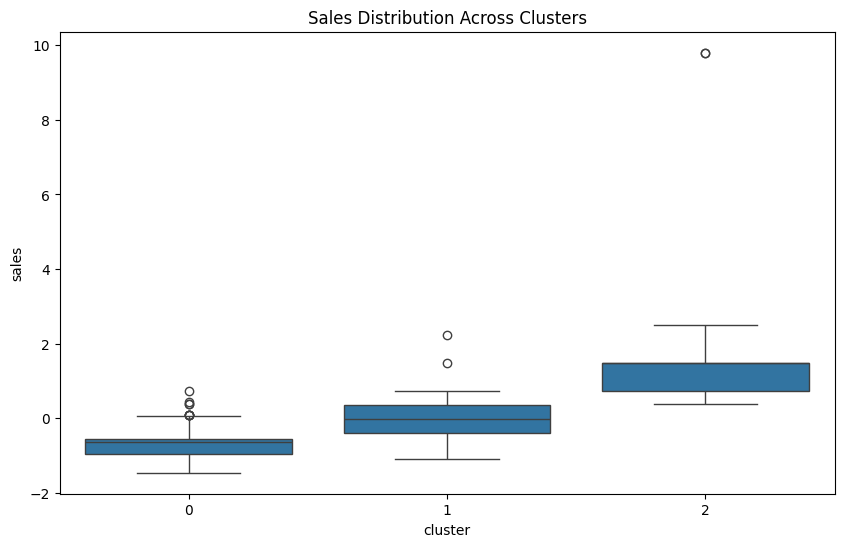

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# For example, to plot the distribution of a feature 'sales' across different clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sampled, x='cluster', y='sales')
plt.title('Sales Distribution Across Clusters')
plt.show()
